<a href="https://colab.research.google.com/github/sathwikaduggineni/Heart_stroke_prediction_final/blob/main/HEART_STROKE_RISK_PREDICTION_FINALCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLING PACKAGES**



In [1]:
!pip install -q catboost xgboost lightgbm imbalanced-learn shap lime optuna tensorflow scikit-learn pandas numpy matplotlib seaborn joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.4 MB/s eta 0:00:00


**IMPORTS & METRICS HELPER FUNCTIONS**


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score,
    matthews_corrcoef, precision_recall_curve, average_precision_score, roc_curve
)

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import shap
from lime import lime_tabular

import joblib
import tensorflow as tf

RND = 42
np.random.seed(RND)
tf.random.set_seed(RND)

# Metric helpers (verified formulae)
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp + 1e-9)

def fbeta_score_custom(y_true, y_pred, beta=2):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    if prec == 0 and rec == 0:
        return 0.0
    beta2 = beta ** 2
    return (1 + beta2) * (prec * rec) / (beta2 * prec + rec + 1e-9)

def evaluate_model(y_true, probs, threshold=0.5):
    preds = (np.array(probs) >= threshold).astype(int)
    # handle case where confusion_matrix.ravel() might fail if only one class present
    try:
        spec = specificity_score(y_true, preds)
        mcc = matthews_corrcoef(y_true, preds)
    except Exception:
        spec = float('nan')
        mcc = float('nan')

    res = {
        'accuracy': float(accuracy_score(y_true, preds)),
        'precision': float(precision_score(y_true, preds, zero_division=0)),
        'recall': float(recall_score(y_true, preds, zero_division=0)),
        'f1': float(f1_score(y_true, preds, zero_division=0)),
        'roc_auc': float(roc_auc_score(y_true, probs)) if len(np.unique(y_true))>1 else float('nan'),
        'balanced_accuracy': float(balanced_accuracy_score(y_true, preds)),
        'specificity': float(spec),
        'mcc': float(mcc),
        'f2': float(fbeta_score_custom(y_true, preds, beta=2))
    }
    return res


**UPLOADING DATASET**

In [3]:
from google.colab import files
print("Please upload stroke_data.csv")
uploaded = files.upload()
if len(uploaded) == 0:
    raise RuntimeError("No file uploaded. Upload stroke_data.csv")

fn = list(uploaded.keys())[0]
print("Uploaded file:", fn)
df = pd.read_csv(fn)
print("Dataset shape:", df.shape)
display(df.head())


Please upload stroke_data.csv


Saving stroke_data.csv.csv to stroke_data.csv.csv
Uploaded file: stroke_data.csv.csv
Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**QUICK INSPECTION**

In [4]:
df.columns = [c.strip() for c in df.columns]

# Drop id if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Check target
if 'stroke' not in df.columns:
    raise ValueError("Target column 'stroke' not found. Rename your target column to 'stroke' (0/1).")

print("Columns:", df.columns.tolist())
print("\nTarget distribution:")
display(df['stroke'].value_counts(dropna=False))
print("\nMissing values per column:")
display(df.isna().sum())


Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Target distribution:


,count
stroke,
0,4861
1,249



Missing values per column:


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


**PREPROCESSING**

In [5]:
df = df.replace({'Unknown': np.nan, 'unknown': np.nan, 'NA': np.nan})

# Coerce numeric columns if they exist
for c in ['age','avg_glucose_level','bmi']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Impute medians and modes
if 'bmi' in df.columns:
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
if 'avg_glucose_level' in df.columns:
    df['avg_glucose_level'] = df['avg_glucose_level'].fillna(df['avg_glucose_level'].median())
if 'smoking_status' in df.columns:
    if df['smoking_status'].notna().any():
        df['smoking_status'] = df['smoking_status'].fillna(df['smoking_status'].mode(dropna=True)[0])
    else:
        df['smoking_status'] = df['smoking_status'].fillna('never')

# Candidate categorical columns (present ones only)
possible_cat = ['gender','ever_married','work_type','Residence_type','smoking_status']
cat_cols = [c for c in possible_cat if c in df.columns]
for c in cat_cols:
    df[c] = df[c].astype('category')

# Final features
features = [c for c in df.columns if c != 'stroke']
print("Using features:", features)


Using features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


**TRAIN/TEST SPLIT, LABEL ENCODING & SCALING**

In [6]:
X = df[features].copy()
y = df['stroke'].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)
print("Train/test sizes:", X_train.shape, X_test.shape)

# Label encode categorical columns
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
label_encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X_train_enc[c] = le.fit_transform(X_train_enc[c].astype(str))
    X_test_enc[c] = le.transform(X_test_enc[c].astype(str))
    label_encoders[c] = le

# Numeric columns scaling for LR/NN
num_cols = [c for c in ['age','avg_glucose_level','bmi'] if c in X_train.columns]
scaler = StandardScaler()
X_train_scaled = X_train_enc.copy()
X_test_scaled = X_test_enc.copy()
if len(num_cols)>0:
    X_train_scaled[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test_enc[num_cols])

# Quick sanity
print("Categorical columns encoded:", cat_cols)
print("Numeric columns scaled:", num_cols)


Train/test sizes: (4088, 10) (1022, 10)
Categorical columns encoded: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numeric columns scaled: ['age', 'avg_glucose_level', 'bmi']


**ADVANCE IMBALANCE STRATEGIES**

In [7]:
print("Original class distribution:", y_train.value_counts().to_dict())

# SMOTE-Tomek
smt = SMOTETomek(random_state=RND)
X_smt, y_smt = smt.fit_resample(X_train_enc, y_train)
print("After SMOTE-Tomek:", np.bincount(y_smt))

# SMOTE-ENN
sme = SMOTEENN(random_state=RND)
X_sme, y_sme = sme.fit_resample(X_train_enc, y_train)
print("After SMOTE-ENN:", np.bincount(y_sme))

# ADASYN
ada = ADASYN(random_state=RND)
X_ada, y_ada = ada.fit_resample(X_train_enc, y_train)
print("After ADASYN:", np.bincount(y_ada))


Original class distribution: {0: 3889, 1: 199}
After SMOTE-Tomek: [3856 3856]
After SMOTE-ENN: [2964 3647]
After ADASYN: [3889 3862]


**MODEL TRAINING**

In [8]:
model_results = {}   # name -> (model_object, probs_on_test)

# 1) Logistic Regression (baseline) - uses scaled features
lr = LogisticRegression(max_iter=1000, random_state=RND)
lr.fit(X_train_scaled, y_train)
probs_lr = lr.predict_proba(X_test_scaled)[:,1]
model_results['LR'] = (lr, probs_lr)

# 2) Random Forest (class_weight='balanced') - uses encoded features
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RND)
rf.fit(X_train_enc, y_train)
probs_rf = rf.predict_proba(X_test_enc)[:,1]
model_results['RF'] = (rf, probs_rf)

# 3) XGBoost - use scale_pos_weight to address imbalance
neg, pos = np.bincount(y_train)
scale_pos = (neg/pos) if pos>0 else 1.0
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos, random_state=RND)
xgb_clf.fit(X_train_enc, y_train)
probs_xgb = xgb_clf.predict_proba(X_test_enc)[:,1]
model_results['XGB'] = (xgb_clf, probs_xgb)

# 4) LightGBM (class_weight='balanced')
lgb_clf = lgb.LGBMClassifier(class_weight='balanced', random_state=RND)
lgb_clf.fit(X_train_enc, y_train)
probs_lgb = lgb_clf.predict_proba(X_test_enc)[:,1]
model_results['LGBM'] = (lgb_clf, probs_lgb)

# 5) CatBoost base (trained on original encoded training data)
cat_base = CatBoostClassifier(iterations=400, learning_rate=0.05, depth=6, random_seed=RND, verbose=0)
cat_base.fit(Pool(X_train_enc, y_train, cat_features=[X_train_enc.columns.get_loc(c) for c in cat_cols] if len(cat_cols)>0 else None))
probs_cat_base = cat_base.predict_proba(X_test_enc)[:,1]
model_results['CAT_base'] = (cat_base, probs_cat_base)

# 6) CatBoost trained on SMOTE-ENN data
cat_sme = CatBoostClassifier(iterations=400, learning_rate=0.05, depth=6, random_seed=RND, verbose=0)
cat_sme.fit(Pool(X_sme, y_sme, cat_features=[X_sme.columns.get_loc(c) for c in cat_cols] if len(cat_cols)>0 else None))
probs_cat_sme = cat_sme.predict_proba(X_test_enc)[:,1]
model_results['CAT_SMOTEENN'] = (cat_sme, probs_cat_sme)

# 7) CatBoost trained on ADASYN
cat_ada = CatBoostClassifier(iterations=400, learning_rate=0.05, depth=6, random_seed=RND, verbose=0)
cat_ada.fit(Pool(X_ada, y_ada, cat_features=[X_ada.columns.get_loc(c) for c in cat_cols] if len(cat_cols)>0 else None))
probs_cat_ada = cat_ada.predict_proba(X_test_enc)[:,1]
model_results['CAT_ADASYN'] = (cat_ada, probs_cat_ada)

print("Trained models:", list(model_results.keys()))


[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Trained models: ['LR', 'RF', 'XGB', 'LGBM', 'CAT_base', 'CAT_SMOTEENN', 'CAT_ADASYN']


**EVALUATION METRICS**

In [9]:
summary_rows = []
for name, (model_obj, probs) in model_results.items():
    ev = evaluate_model(y_test, probs, threshold=0.5)
    ev['model'] = name
    summary_rows.append(ev)

df_summary = pd.DataFrame(summary_rows).set_index('model').sort_values(by='recall', ascending=False)
pd.options.display.float_format = '{:.4f}'.format
display(df_summary[['recall','f2','balanced_accuracy','specificity','mcc','roc_auc','accuracy','precision','f1']])


,recall,f2,balanced_accuracy,specificity,mcc,roc_auc,accuracy,precision,f1
model,,,,,,,,,
CAT_SMOTEENN,0.6000,0.3876,0.7192,0.8385,0.2446,0.8133,0.8268,0.1604,0.2532
LGBM,0.3200,0.3030,0.6353,0.9506,0.2409,0.8226,0.9198,0.2500,0.2807
CAT_ADASYN,0.2200,0.1871,0.5673,0.9146,0.1005,0.7679,0.8806,0.1170,0.1528
XGB,0.1800,0.1923,0.5771,0.9743,0.1856,0.7969,0.9354,0.2647,0.2143
CAT_base,0.0200,0.0243,0.5074,0.9949,0.0419,0.8280,0.9472,0.1667,0.0357
RF,0.0000,0.0000,0.4995,0.9990,-0.0071,0.7732,0.9501,0.0000,0.0000
LR,0.0000,0.0000,0.5000,1.0000,0.0000,0.8381,0.9511,0.0000,0.0000


Best model by recall: CAT_SMOTEENN


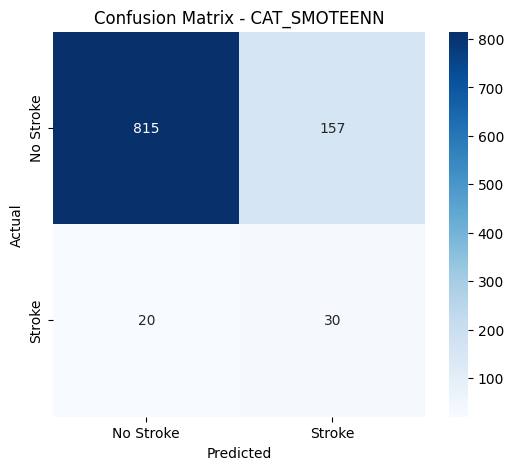

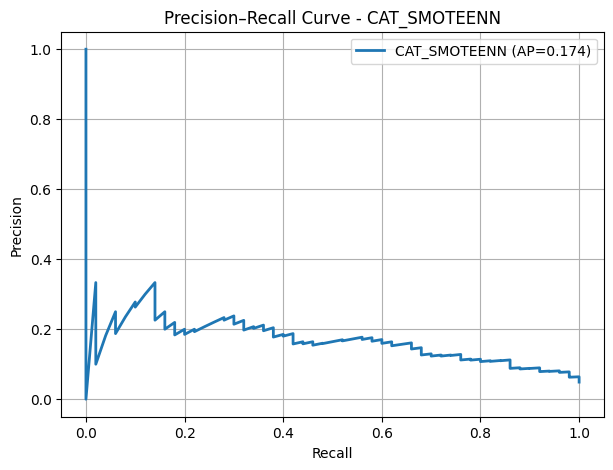

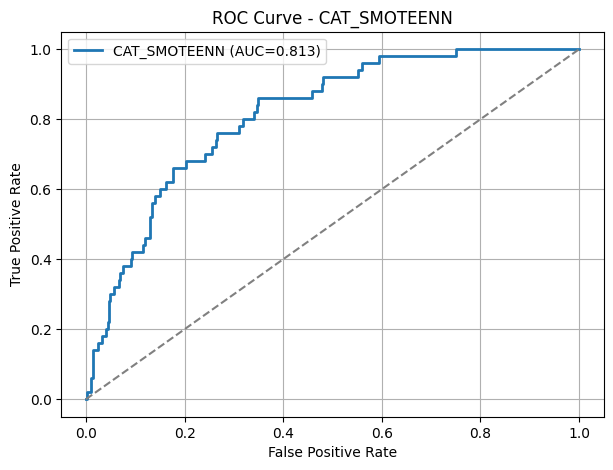

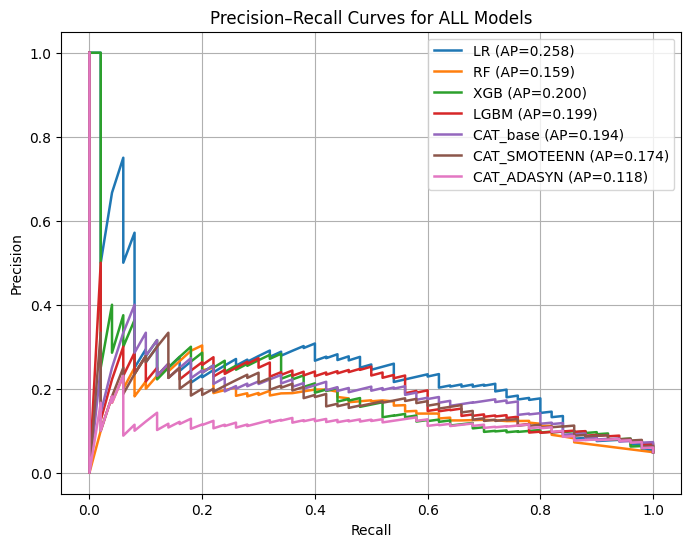

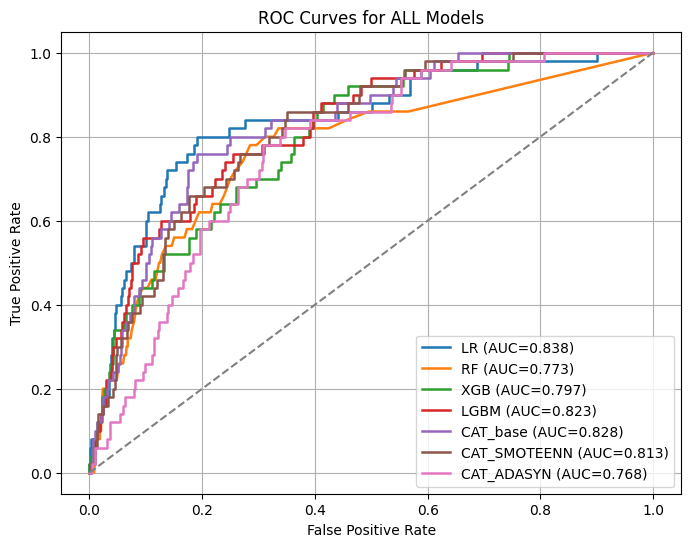

In [25]:
# Select best model by recall
best_model_name = df_summary.index[0]
best_model_obj, best_probs = model_results[best_model_name]
print("Best model by recall:", best_model_name)

# Predictions for best model
best_preds = (best_probs >= 0.5).astype(int)

# Confusion Matrix — Best Model
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke','Stroke'],
            yticklabels=['No Stroke','Stroke'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#Precision–Recall Curve — Best Model Only

prec_b, rec_b, _ = precision_recall_curve(y_test, best_probs)
ap_b = average_precision_score(y_test, best_probs)

plt.figure(figsize=(7,5))
plt.plot(rec_b, prec_b, label=f'{best_model_name} (AP={ap_b:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - {best_model_name}')
plt.grid(True)
plt.legend()
plt.show()


#ROC Curve — Best Model Only

fpr_b, tpr_b, _ = roc_curve(y_test, best_probs)
auc_b = roc_auc_score(y_test, best_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr_b, tpr_b, label=f'{best_model_name} (AUC={auc_b:.3f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.grid(True)
plt.legend()
plt.show()


# Precision–Recall Curves for ALL Models
plt.figure(figsize=(8,6))

for name, (model, probs) in model_results.items():
    prec, rec, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(rec, prec, label=f'{name} (AP={ap:.3f})', linewidth=1.8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves for ALL Models')
plt.legend()
plt.grid(True)
plt.show()

#ROC Curves for ALL Models
plt.figure(figsize=(8,6))

for name, (model, probs) in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=1.8)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ALL Models')
plt.legend()
plt.grid(True)
plt.show()


**SHAP GLOBAL EXPLAINABILITY**

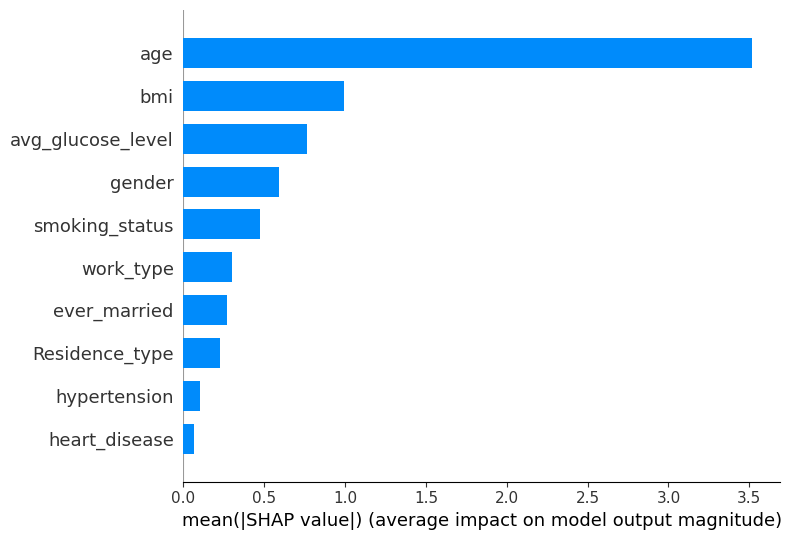

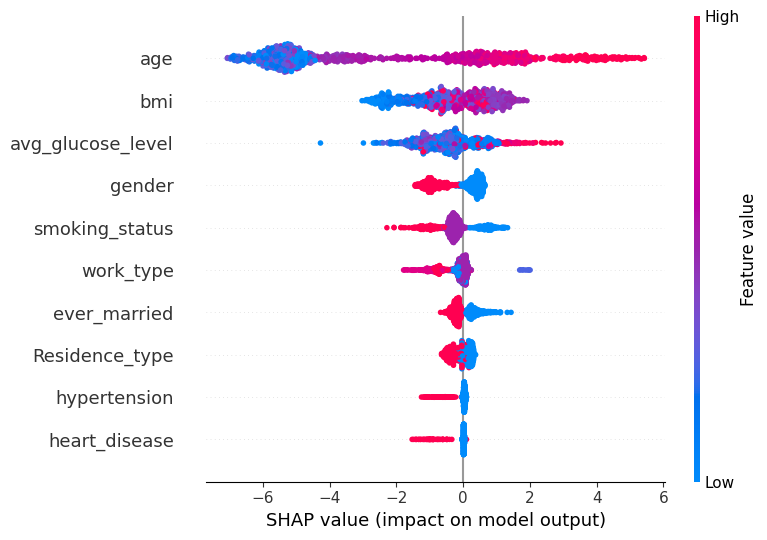

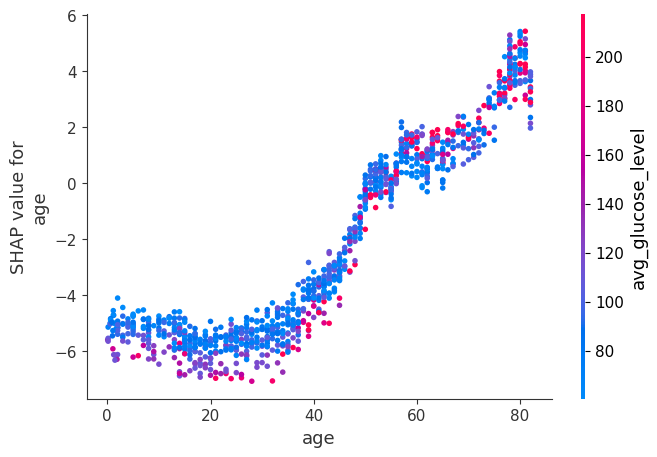

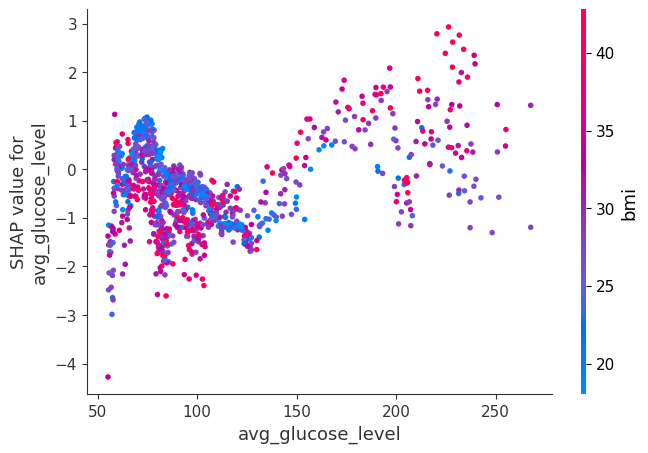

In [12]:
best_name = best_model_name
best_model = model_results[best_name][0]

# Choose explainer depending on model type
if any(cls in type(best_model).__name__ for cls in ['XGB','LGBM','CatBoost','RandomForest']):
    explainer = shap.TreeExplainer(best_model)
    shap_vals = explainer.shap_values(X_test_enc)
    shap.summary_plot(shap_vals, X_test_enc, plot_type='bar', show=True)
    shap.summary_plot(shap_vals, X_test_enc, show=True)
    for col in ['age','avg_glucose_level']:
        if col in X_test_enc.columns:
            shap.dependence_plot(col, shap_vals, X_test_enc, show=True)
else:
    # KernelExplainer as fallback (use small background sample to keep it practical)
    background = shap.sample(X_train_scaled, 100, random_state=RND)
    explainer = shap.KernelExplainer(best_model.predict_proba, background)
    sample = X_test_scaled.sample(100, random_state=RND)
    shap_vals = explainer.shap_values(sample)
    shap.summary_plot(shap_vals[1], sample, show=True)


**LOCAL EXPLAINABILITY : SHAP FORCE & LIME FOR MISCLASSIFIED EXAMPLES**

Selected indices for local explainability: [137, 159, 133, 190, 94]



Index 137 | true=1 | pred=1 | prob=0.6420


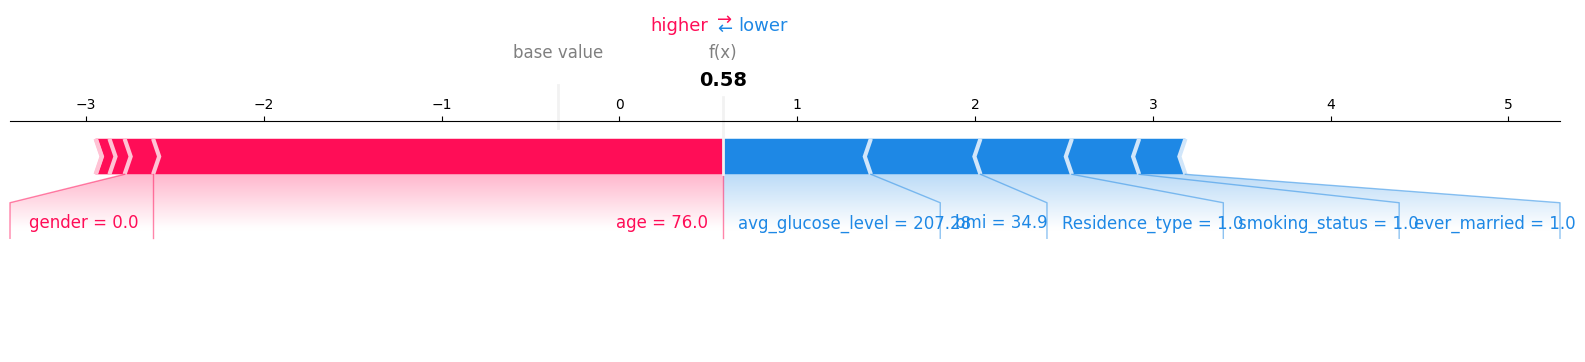

None


Index 159 | true=1 | pred=1 | prob=0.9823


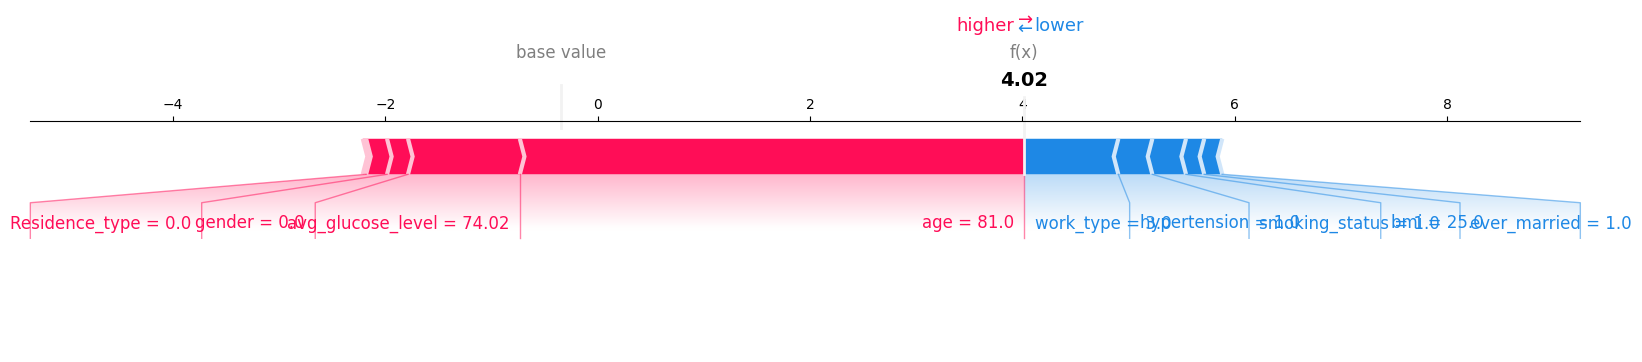

None


Index 133 | true=1 | pred=0 | prob=0.2059


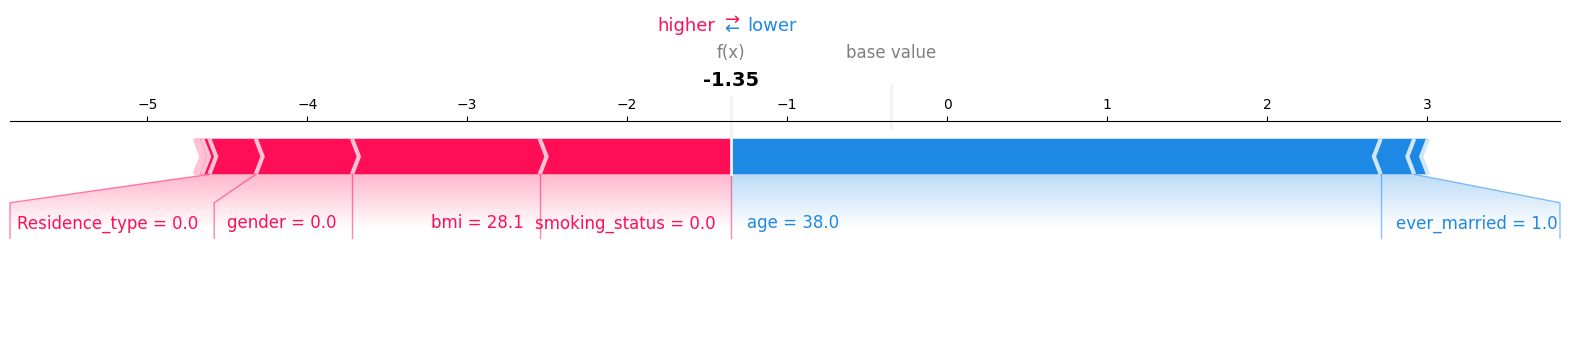

None


Index 190 | true=1 | pred=0 | prob=0.2415


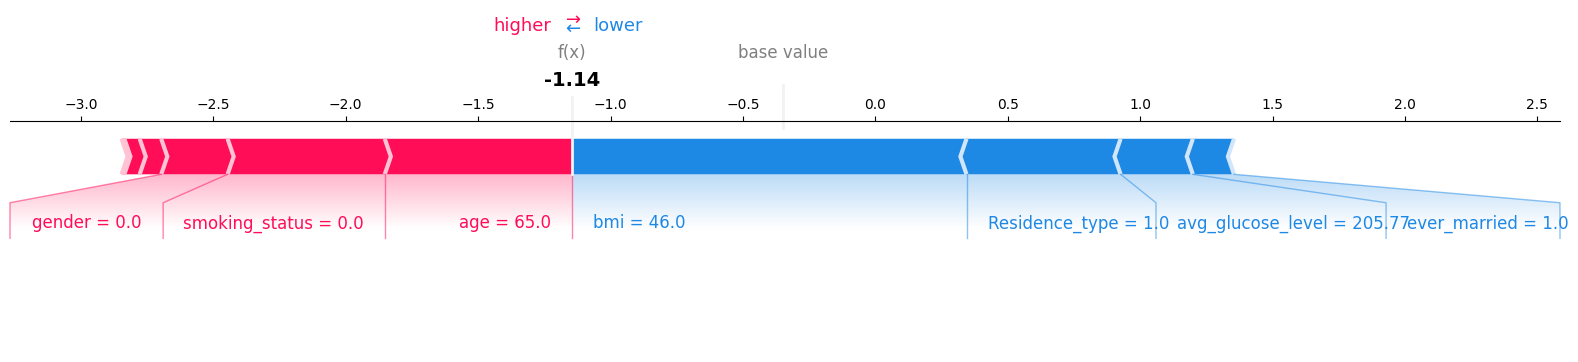

None


Index 94 | true=1 | pred=0 | prob=0.0195


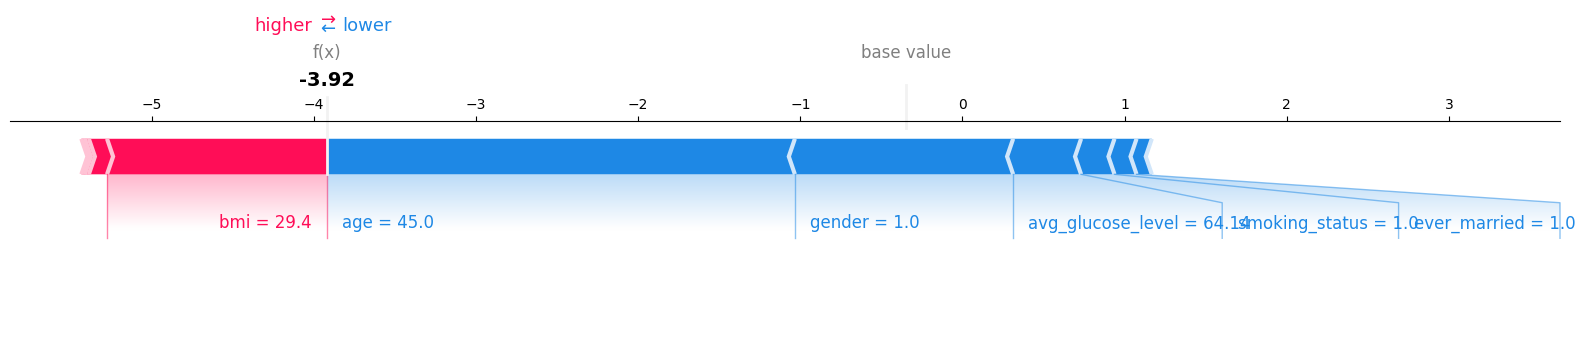

None

LIME explanation (top 8 contributions):
[('age > 61.00', 0.49715984125200646),
 ('work_type <= 2.00', 0.1739346262810897),
 ('heart_disease <= 0.00', 0.08280680228450592),
 ('smoking_status <= 1.00', 0.07697764034360736),
 ('0.00 < gender <= 1.00', -0.07394086359272246),
 ('hypertension <= 0.00', 0.06915238154142718),
 ('0.00 < ever_married <= 1.00', -0.0685605835261716),
 ('23.80 < bmi <= 28.10', 0.040002308346648315)]


In [24]:
best_probs = model_results[best_model_name][1]
best_preds = (best_probs >= 0.5).astype(int)
test_idx = X_test_enc.index

# Find up to 2 true positives and up to 3 false negatives
tp_idx = X_test_enc[(y_test==1) & (best_preds==1)].index.tolist()[:2]
fn_idx = X_test_enc[(y_test==1) & (best_preds==0)].index.tolist()[:3]
selected = tp_idx + fn_idx
print("Selected indices for local explainability:", selected)

shap.initjs()
try:
    for idx in selected:
        i = list(test_idx).index(idx)
        print(f"\nIndex {idx} | true={int(y_test.loc[idx])} | pred={best_preds[i]} | prob={best_probs[i]:.4f}")
        display(shap.force_plot(explainer.expected_value, shap_vals[i,:], X_test_enc.iloc[i,:], matplotlib=True))
except Exception as e:
    print("Local SHAP visualization issue (may still be OK):", e)

# LIME for one misclassified sample (if any)
mis_idx = X_test_enc[(best_preds != y_test)].index.tolist()
if len(mis_idx) > 0:
    idx = mis_idx[0]

    # Wrapper function for CatBoost predict_proba to handle LIME's numpy array input
    def catboost_predict_proba_wrapper(data_array):
        # data_array will be a 2D numpy array from LIME
        # Recreate DataFrame structure to correctly identify categorical features for CatBoost
        df_for_prediction = pd.DataFrame(data_array, columns=X_train_enc.columns)

        # Explicitly convert categorical columns back to integer type
        for c in cat_cols:
            if c in df_for_prediction.columns:
                # Use .round() before astype(int) to handle potential floating point inaccuracies from LIME
                df_for_prediction[c] = df_for_prediction[c].round().astype(int)

        # Get the indices of the categorical features
        cat_feature_indices = [df_for_prediction.columns.get_loc(c) for c in cat_cols if c in df_for_prediction.columns]

        # Create a CatBoost Pool for prediction
        cat_pool_for_lime = Pool(df_for_prediction, cat_features=cat_feature_indices)

        return best_model.predict_proba(cat_pool_for_lime)

    lime_explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train_enc.values,
        feature_names=X_train_enc.columns.tolist(),
        class_names=['no_stroke','stroke'],
        mode='classification'
    )
    exp = lime_explainer.explain_instance(X_test_enc.loc[idx].values, catboost_predict_proba_wrapper, num_features=8)
    print("LIME explanation (top 8 contributions):")
    pprint(exp.as_list())
else:
    print("No misclassified samples to explain with LIME.")

**FAIRNESS**

In [16]:
fair_df = X_test.copy()
for c in cat_cols:
    if c in fair_df.columns:
        # put original labels (non-encoded) if available in X_test
        fair_df[c] = X_test[c]
fair_df['y_true'] = y_test
fair_df['y_pred'] = best_preds
fair_df['prob'] = best_probs

def group_metrics(df, col):
    metrics = {}
    for g in df[col].dropna().unique():
        sub = df[df[col]==g]
        if len(sub)==0:
            continue
        tpr = recall_score(sub['y_true'], sub['y_pred'], zero_division=0)
        sel_rate = sub['y_pred'].mean()
        metrics[g] = {'tpr': float(tpr), 'selection_rate': float(sel_rate), 'count': int(len(sub))}
    return metrics

if 'gender' in fair_df.columns:
    print("Gender group metrics:")
    pprint(group_metrics(fair_df, 'gender'))
if 'Residence_type' in fair_df.columns:
    print("Residence group metrics:")
    pprint(group_metrics(fair_df, 'Residence_type'))
if 'age' in fair_df.columns:
    fair_df['age_group'] = pd.cut(fair_df['age'], bins=[0,30,45,60,120], labels=['0-30','31-45','46-60','61+'])
    print("Age-group metrics:")
    pprint(group_metrics(fair_df, 'age_group'))


Gender group metrics:
{'Female': {'count': 599,
            'selection_rate': 0.18697829716193656,
            'tpr': 0.6896551724137931},
 'Male': {'count': 423,
          'selection_rate': 0.1773049645390071,
          'tpr': 0.47619047619047616}}
Residence group metrics:
{'Rural': {'count': 495,
           'selection_rate': 0.21212121212121213,
           'tpr': 0.6086956521739131},
 'Urban': {'count': 527,
           'selection_rate': 0.1555977229601518,
           'tpr': 0.5925925925925926}}
Age-group metrics:
{'0-30': {'count': 329, 'selection_rate': 0.0, 'tpr': 0.0},
 '31-45': {'count': 216, 'selection_rate': 0.0, 'tpr': 0.0},
 '46-60': {'count': 217, 'selection_rate': 0.18433179723502305, 'tpr': 0.2},
 '61+': {'count': 260,
         'selection_rate': 0.5653846153846154,
         'tpr': 0.7631578947368421}}


**RISK STRATIFICATION**

In [15]:
prob_series = pd.Series(best_probs, index=X_test_enc.index)
risk_bin = pd.cut(prob_series, bins=[0,0.3,0.7,1.0], labels=['Low','Medium','High'])
risk_df = pd.DataFrame({'prob': prob_series, 'risk_prob': risk_bin, 'true': y_test})
display(risk_df.groupby('risk_prob').agg({'true':['count','sum','mean']}))

# SHAP-sum alternative if shap_vals available
try:
    shap_sum = np.abs(shap_vals).sum(axis=1)
    rs = pd.Series(shap_sum, index=X_test_enc.index)
    q1, q2 = np.quantile(rs, [0.33, 0.66])
    risk_shap = rs.apply(lambda s: 'Low' if s<q1 else ('Medium' if s<q2 else 'High'))
    risk_df['risk_shap'] = risk_shap
    display(risk_df.groupby('risk_shap').agg({'true':['count','sum','mean']}))
except Exception:
    pass


true           
          count sum   mean
risk_prob                 
Low         758  16 0.0211
Medium      130  12 0.0923
High        134  22 0.1642

true           
          count sum   mean
risk_shap                 
High        348   8 0.0230
Low         337  18 0.0534
Medium      337  24 0.0712